In [11]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import backend as K

In [12]:
import sys
sys.path.append('scripts/')
from simulation_based_likelihood import *
from synthetic_data import *
from simba_gradient_univariate import *

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [14]:
# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 24  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 24  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 30  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 34  # Font size of title

In [15]:
import pylab 
import scipy.stats as stats

from scipy import stats

chi2 = stats.chi2
gaussian = stats.norm

# SimBa-CL optimization and empirical coverage

Here we show how to optimize Simba-CL and how to compute gradients and hessians for the composite likelihood asymptotics. Even though for our 2-dim scenario we use vanilla gradient descent here we show how to use Adam. 

In [ ]:
covariates_n = 2

M = 2
N = 300

T = 100

W_tensor = tf.convert_to_tensor(np.load("data/optimization/covariates.npy"), dtype = tf.float32)[:N,...]

input_0      = tuple([W_tensor])
input_kernel = tuple([W_tensor])

model = compartmental_model(N, input_0, input_kernel, SIS_initial, SIS_transition)

initial_infection_rate = 0.01
beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
beta_lambda = tf.convert_to_tensor( [-1,           +2],      dtype = tf.float32 )  
beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
epsilon     = tf.convert_to_tensor( [0.001],                  dtype = tf.float32 )  

parameters_0 = tuple([beta_0])
parameters_kernel = beta_lambda, beta_gamma, epsilon

q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
q_static = tf.convert_to_tensor([0.6, 0.4], dtype = tf.float32)

q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

parameters_emission = tuple([q_static])

parallel_simulations = 100

tf.random.set_seed((N+T))
np.random.seed((N+T))

seed_gen_optim_experiment = tfp.random.split_seed( (N+T), n=2, salt='optimization_SGD_N1000_T100')

x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_gen_optim_experiment[1][0])

In [21]:
optimization_steps = 200
lr_rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate)

simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, 
						    SIS_initial_grad, SIS_transition_grad, SIS_emission_grad)


In [ ]:
initial_lambda = tf.Variable(tf.convert_to_tensor(np.random.uniform(-3, 3, 2), dtype = tf.float32))

seed_init_cond_optim = tfp.random.split_seed( seed_gen_optim_experiment[0][0], n= optimization_steps+1, salt='optimization_SGD_N1000_T100_optim_steps')

for epoch in range(optimization_steps):
    print("Epoch ", epoch)
    print("Parameters ", initial_lambda.numpy())

    seed_simba_loss, seed_optimization = tfp.random.split_seed( seed_init_cond_optim[epoch][0], n= 2, salt='optimization_SGD_N1000_T100_epoch')

    parameters_kernel_optim = initial_lambda, beta_gamma, epsilon

    gradient = simba_loss_grad(simulation_likelihood_model, initial_lambda, parameters_0, parameters_kernel_optim, parameters_emission, y, seed_optimization[0])

    # Apply gradients to update the parameters_var
    optimizer.apply_gradients(zip([gradient], [initial_lambda]))


Epoch  0
Parameters  [-2.1107051 -2.9277096]
Epoch  1
Parameters  [-2.010711 -2.827738]
Epoch  2
Parameters  [-1.910609 -2.727894]
Epoch  3
Parameters  [-1.8103085 -2.6296542]
Epoch  4
Parameters  [-1.7104146 -2.5304234]
Epoch  5
Parameters  [-1.6105014 -2.4303877]
Epoch  6
Parameters  [-1.5109761 -2.3300397]
Epoch  7
Parameters  [-1.4112095 -2.230321 ]
Epoch  8
Parameters  [-1.3117806 -2.1306977]
Epoch  9
Parameters  [-1.2162358 -2.0376382]
Epoch  10
Parameters  [-1.1222252 -1.9431918]
Epoch  11
Parameters  [-1.0296699 -1.8478037]
Epoch  12
Parameters  [-0.93568236 -1.7521913 ]
Epoch  13
Parameters  [-0.84374577 -1.655015  ]
Epoch  14
Parameters  [-0.7518028 -1.5585674]
Epoch  15
Parameters  [-0.66140294 -1.4615018 ]
Epoch  16
Parameters  [-0.57416373 -1.3624744 ]
Epoch  17
Parameters  [-0.49077243 -1.2617882 ]
Epoch  18
Parameters  [-0.41221878 -1.1602788 ]
Epoch  19
Parameters  [-0.3395582 -1.0579324]
Epoch  20
Parameters  [-0.2738855 -0.9555371]
Epoch  21
Parameters  [-0.21389657 -

Gradients and Hessians can be then computed with the following cells (we use a small number of Monta Carlo simulations and bootstrap to reduce the computational cost).

This is without Barlett

In [10]:
parallel_simulations = 50

iterations = 10

seed_gen_double = tfp.random.split_seed( (N+T), n=2, salt='full_coverage_N1000_T300_double_split')
seed_gen_optim_experiment = tfp.random.split_seed( seed_gen_double[1][0], n=2, salt='full_gradient_hessian_sample')

beta_lambda_optim = initial_lambda
parameters_kernel_optim = beta_lambda_optim, beta_gamma, epsilon

y_sim = y

loss = simba_loss(simulation_likelihood_model, parameters_0, parameters_kernel_optim, parameters_emission, y_sim, seed_gen_double[1][0])
grad = simba_loss_grad(simulation_likelihood_model, beta_lambda_optim, parameters_0, parameters_kernel_optim, parameters_emission, y_sim, seed_gen_double[1][0])

In [23]:
gradient_sample_, hessian_sample_  = gradient_hessian_sample( simulation_likelihood_model, beta_lambda_optim, parameters_0, parameters_kernel_optim, parameters_emission, T, N, M, iterations, seed_gen_optim_experiment[1][0])

This is with Barlett

In [12]:
individuals_gradient_sample_  = individual_gradients_sample(simulation_likelihood_model, beta_lambda_optim, parameters_0, parameters_kernel_optim, parameters_emission, T, N, M, iterations, seed_gen_optim_experiment[0][0])

Now we build the confidence intervals with and without Barlett

In [32]:
theta = beta_lambda
theta_hat      = beta_lambda_optim

In [33]:
gradient_optim  = gradient_sample_
hessian_optim = hessian_sample_

H_expected = np.mean(-hessian_optim, axis = 0)

centered_gradients_sgd = gradient_optim - np.mean(gradient_optim, axis = 0, keepdims = True)
J_expected = (np.einsum("bp,bq->pq", centered_gradients_sgd, centered_gradients_sgd))/(centered_gradients_sgd.shape[0]-1)

G = np.dot(np.dot(H_expected, np.linalg.inv(J_expected)), H_expected)

In [41]:
individuals_sgd = individuals_gradient_sample_

H_expected_barlett = np.mean(np.einsum("bnp,bnq->bpq", individuals_sgd, individuals_sgd), axis = 0)
J_expected_barlett = np.mean(np.einsum("bnp,bmq->bpq", individuals_sgd, individuals_sgd), axis = 0)

G_barlett = np.dot(np.dot(H_expected_barlett, np.linalg.inv(J_expected_barlett)), H_expected_barlett)

In [42]:
def confidence_ellipse(mean, cov, ax, critical_value, facecolor='none', **kwargs):
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * np.sqrt(critical_value)
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * np.sqrt(critical_value)
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

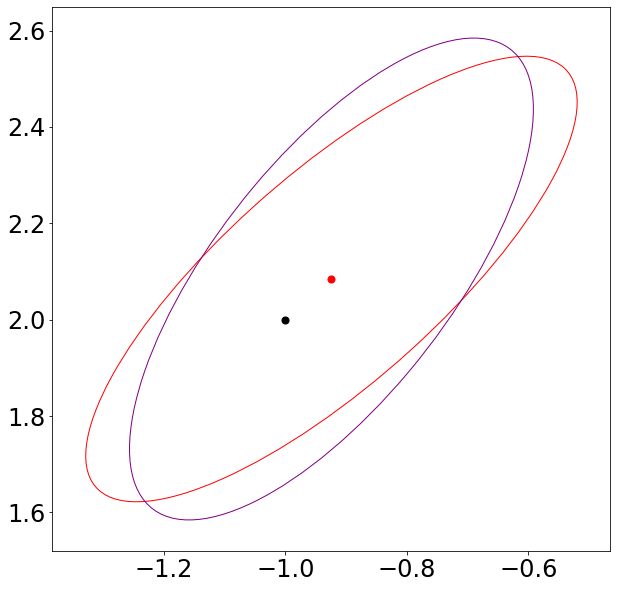

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(theta[0], theta[1], c='black', s=50)
ax.scatter(theta_hat[0], theta_hat[1], c='red', s=50)

# Critical value for 95% confidence level
alpha = 0.05
critical_value = chi2.ppf(1-alpha, 2)
    
confidence_ellipse(theta_hat, np.linalg.inv(G), ax, critical_value, edgecolor='red')
confidence_ellipse(theta_hat, np.linalg.inv(G_barlett), ax, critical_value, edgecolor='purple')

For the 9-dimensional case the script simba_gradient needs to be used. 

For completeness we show how to reproduce our paper figures for both the 2-dim and the 9-dim scenario.

## Paper figures

### 2 parameters

In [44]:
parameters_sgd_path = []
log_like_sgd_path = []

for path in ["optimization_SGD_N100_T100", "optimization_SGD_N100_T300", "optimization_SGD_N1000_T100", "optimization_SGD_N1000_T300"]:    

    parameters_sgd = []
    log_like_sgd = []

    for i in range(20):

        # if i!=13 and i!=18:
            parameters_load = np.load("data/optimization/optimization_partial/"+path+"/optimization_"+str(i)+"_params.npy")
            log_like_load = np.load("data/optimization/optimization_partial/"+path+"/optimization_"+str(i)+"_log_like_optim.npy")
            
            index_best = np.argmax((np.load("data/optimization/optimization_partial/"+path+"/optimization_"+str(i)+"_log_like_optim.npy")[...,-1]), axis = 1)

            parameters_best = np.zeros((parameters_load.shape[0], parameters_load.shape[2]))
            log_like_best = np.zeros((log_like_load.shape[0], log_like_load.shape[2]))

            for ind in range(index_best.shape[0]):
                parameters_best[ind, :] = parameters_load[ind,index_best[ind], :]
                log_like_best[ind,:]    = log_like_load[ind,index_best[ind], :]

            parameters_sgd.append(parameters_best)
            log_like_sgd.append(log_like_best)

    parameters_sgd = np.concatenate(parameters_sgd, axis =0)
    parameters_sgd = parameters_sgd[np.where(~np.isnan(np.sum(parameters_sgd, axis =1))),:][0,...]
    parameters_sgd = parameters_sgd[np.where(np.sum(parameters_sgd, axis =1)!=0),:][0,...]

    log_like_sgd = np.concatenate(log_like_sgd, axis =0)

    parameters_sgd_path.append(parameters_sgd)

    log_like_sgd_path.append(log_like_sgd)


In [49]:
gradients_sgd = []
hessians_sgd = []
params_optim_sgd = []
individuals_sgd = []

gradients_sgd_obs = []
hessians_sgd_obs = []
individuals_sgd_obs = []

for i in range(20):

        gradients_load = np.load("data/optimization/optimization_partial/grad_hessian_N1000_T300/optimization_"+str(i)+"_gradients.npy")
        gradients_sgd.append(gradients_load)
        
        hessians_load = np.load("data/optimization/optimization_partial/grad_hessian_N1000_T300/optimization_"+str(i)+"_hessians.npy")
        hessians_sgd.append(hessians_load)

        # We could not include it in the Github repo but we are more than happy to provide it if you are interested
        # indivs_load = np.load("data/optimization_partial/grad_hessian_N1000_T300_barlett/optimization_"+str(i)+"_gradients.npy")
        # individuals_sgd.append(indivs_load)
    

gradients_sgd = np.concatenate(gradients_sgd, axis =0)
hessians_sgd  = np.concatenate(hessians_sgd,  axis =0)
# individuals_sgd      = np.concatenate(individuals_sgd,  axis =0)

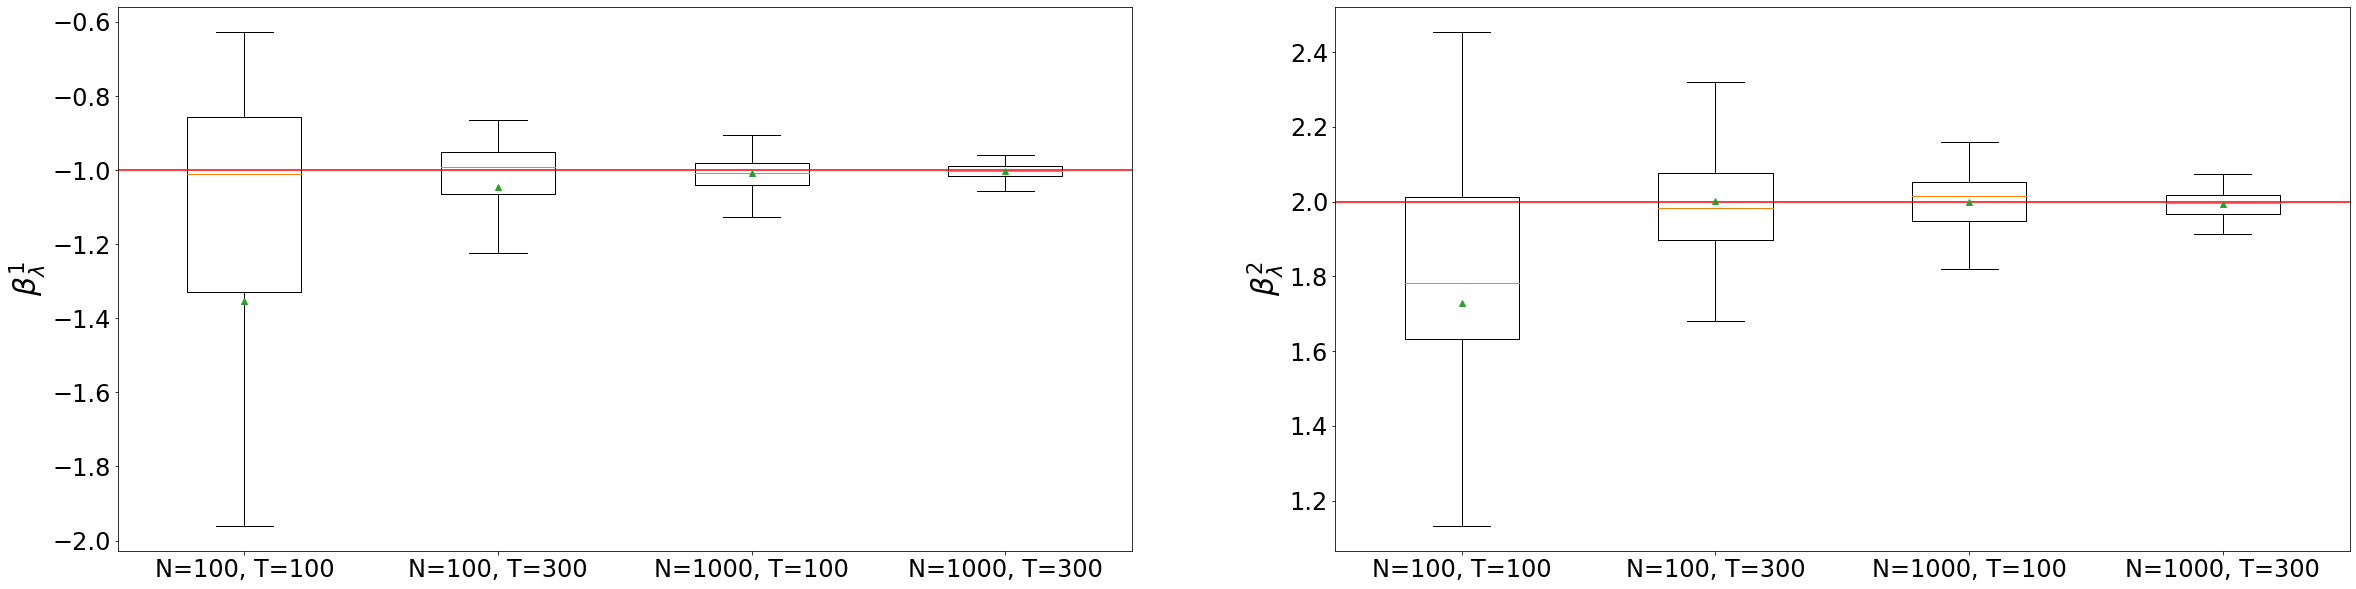

In [51]:
names_list = [r"$\beta_\lambda^1$", r"$\beta_\lambda^2$"]

parameters_true = np.array([-1, 2])

fig, ax = plt.subplots(1, 2, figsize=(40, 10))

names = [r"$\beta_{\lambda}^1$", r"$\beta_{\lambda}^2$"]
ticks_names =[r"N=100,"+" T=100", r"N=100,"+" T=300", r"N=1000,"+" T=100", r"N=1000,"+" T=300",]

for j in range(2):
            
    ax[j].boxplot([parameters_sgd_path[0][:,j], parameters_sgd_path[1][:,j], parameters_sgd_path[2][:,j], parameters_sgd_path[3][:,j]], showfliers=False, showmeans=True)
    ax[j].set_ylabel(names[j])
    ax[j].set_xticklabels(ticks_names)
    ax[j].axhline(y = parameters_true[j], color = "red")

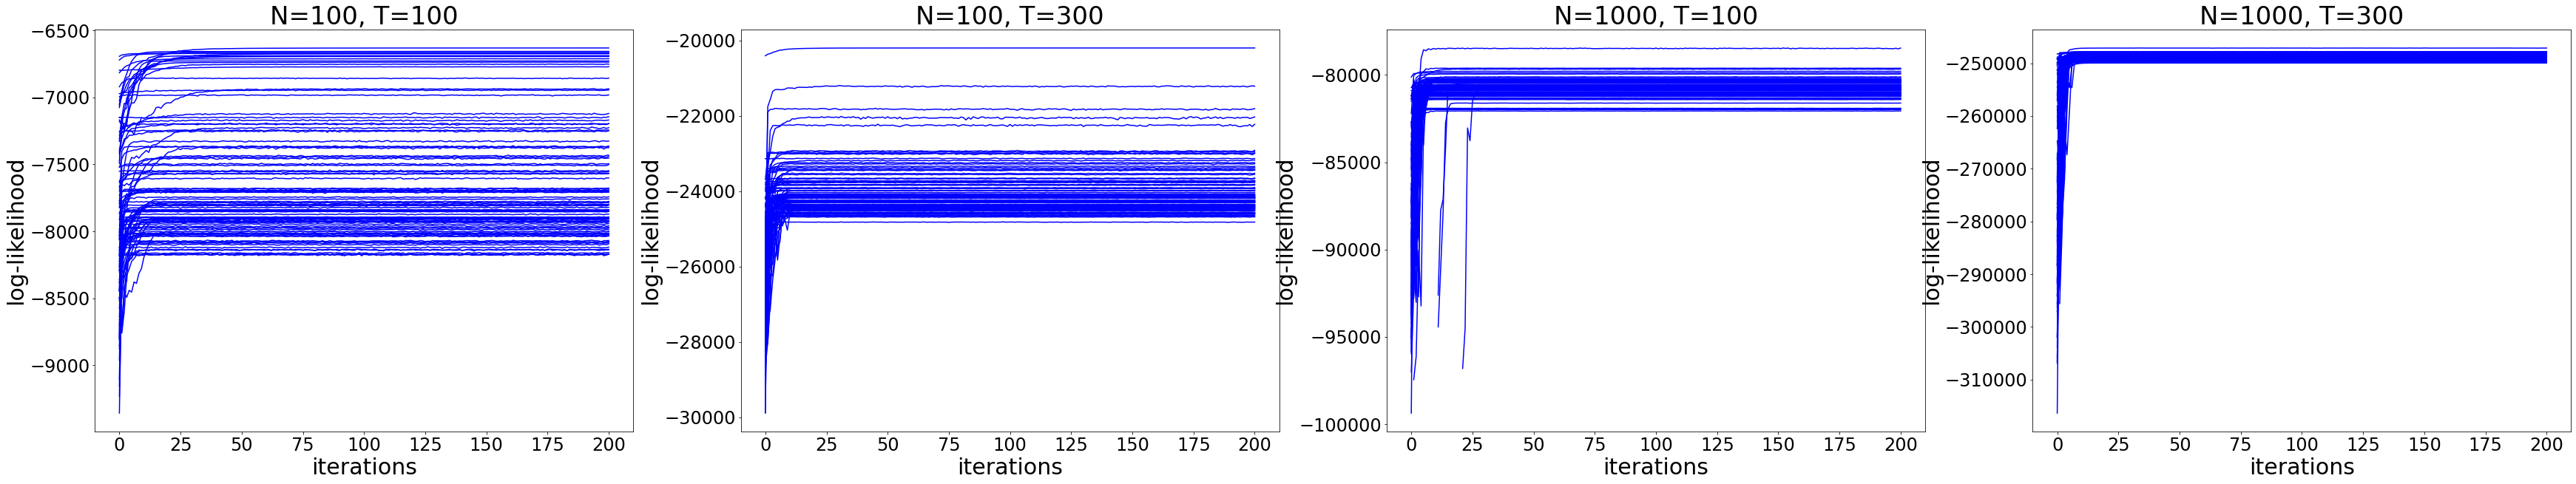

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(60, 10))

names = [r"$\beta_{\lambda}^1$", r"$\beta_{\lambda}^2$"]
ticks_names =[r"N=100,"+" T=100", r"N=100,"+" T=300", r"N=1000,"+" T=100", r"N=1000,"+" T=300",]

for j in range(4):

    for i in range(100):
            
        ax[j].plot(log_like_sgd_path[j][i,:], color = "blue")

    ax[j].set_title(ticks_names[j])
    ax[j].set_xlabel("iterations")
    ax[j].set_ylabel("log-likelihood")

In [53]:
theta_hat = parameters_sgd_path[3]

H_expected = np.mean(-hessians_sgd, axis = 1)

centered_gradients_sgd = gradients_sgd - np.mean(gradients_sgd, axis = 1, keepdims = True)
J_expected = (np.einsum("sbp,sbq->spq", centered_gradients_sgd, centered_gradients_sgd))/(centered_gradients_sgd.shape[1]-1)

In [54]:
top_CI = []
low_CI = []
coverage = []

# Critical value for 95% confidence level
alpha = 0.05
critical_value = chi2.ppf(1-alpha, 2)

theta = parameters_true
theta_hat = parameters_sgd_path[3]

for i in range(theta_hat.shape[0]):

    # Estimate of theta
    theta_hat_sim = theta_hat[i,...]

    G = np.dot(np.dot(H_expected[i,...], np.linalg.inv(J_expected[i,...])), H_expected[i,...])

    W = np.dot(np.dot((theta_hat_sim-theta), G), (theta_hat_sim-theta))

    # print(W)

    within_CI = ((W) <= critical_value)
    # print(within_CI)

    if within_CI==False:
        break
    coverage.append(within_CI)

np.mean(np.stack(coverage), axis =0)

1.0

In [55]:
top_CI = []
low_CI = []
coverage = []

# Critical value for 95% confidence level
alpha = 0.05 
critical_value = gaussian.ppf(1-alpha/2)

theta = parameters_true
theta_hat = theta_hat = parameters_sgd_path[3]

for i in range(theta_hat.shape[0]):

    # Estimate of theta
    theta_hat_sim = theta_hat[i,...]

    G = np.dot(np.dot(H_expected[i,...], np.linalg.inv(J_expected[i,...])), H_expected[i,...])

    Sigma = np.linalg.inv(G)

    correlation = Sigma[0,1]/np.prod(np.sqrt(np.diag(Sigma)))

    var_ratio = np.sqrt(np.diag(Sigma)[0]/np.diag(Sigma)[1])
    bias_corrected = (theta_hat_sim[::-1] - theta[::-1])*correlation*[var_ratio, 1/var_ratio]

    top_CI_hat = theta_hat_sim + critical_value*np.sqrt(np.diag(Sigma))  
    low_CI_hat = theta_hat_sim - critical_value*np.sqrt(np.diag(Sigma)) 

    within_CI = (theta <= top_CI_hat)*(theta >= low_CI_hat)
    coverage.append(within_CI)

    top_CI.append(top_CI_hat)
    low_CI.append(low_CI_hat)


top_CI = np.stack(top_CI, axis =0)
low_CI = np.stack(low_CI, axis =0)

np.mean(np.stack(coverage), axis =0)

array([1.  , 0.99])

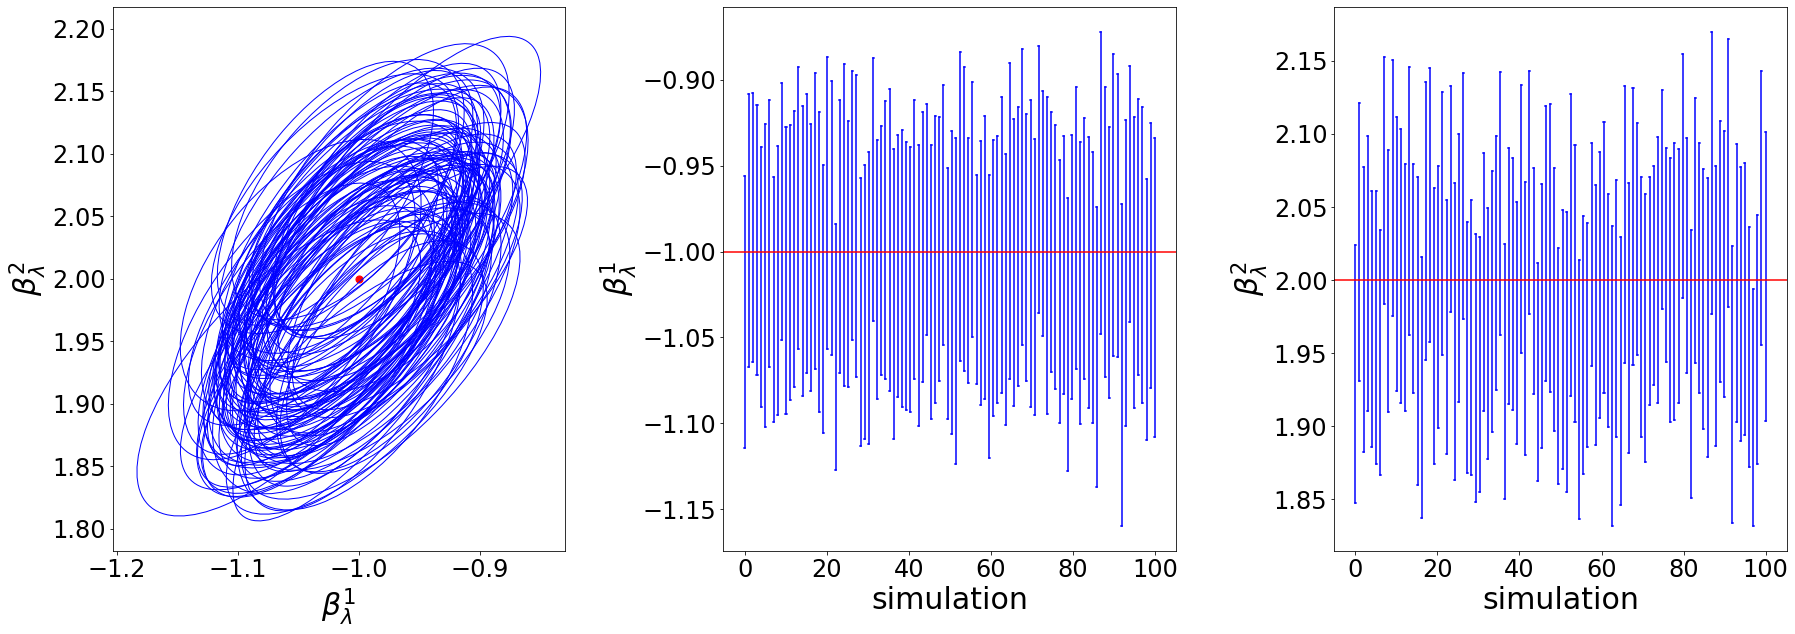

In [56]:
def plot_confidence_interval(locations, theta_hat, top_CI, low_CI, horizontal_line_width, color, ax):
    
    for i in range(theta_hat.shape[0]):

        mean = theta_hat[i]

        left = locations[i] - horizontal_line_width / 2
        top = top_CI[i]
        right = locations[i] + horizontal_line_width / 2
        bottom = low_CI[i]

        ax.plot([locations[i], locations[i]], [top, bottom], color=color)
        ax.plot([left, right], [top, top], color=color)
        ax.plot([left, right], [bottom, bottom], color=color)
        # ax.plot(locations[i], mean, 'o', color='#f44336')

fig, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].scatter(theta[0], theta[1], c='red', s=50)
ax[0].set_xlabel(r"$\beta_\lambda^1$")
ax[0].set_ylabel(r"$\beta_\lambda^2$")

alpha = 0.05
critical_value_ellipse = chi2.ppf(1-alpha, 2)

for i in range(theta_hat.shape[0]):
    # Estimate of theta
    theta_hat_sim = theta_hat[i,...]

    G = np.dot(np.dot(H_expected[i,...], np.linalg.inv(J_expected[i,...])), H_expected[i,...])
    
    confidence_ellipse(theta_hat_sim, np.linalg.inv(G), ax[0], critical_value_ellipse, edgecolor='blue')


ax[1].set_xlabel(r"simulation")
ax[1].set_ylabel(r"$\beta_\lambda^1$")


ax[2].set_xlabel(r"simulation")
ax[2].set_ylabel(r"$\beta_\lambda^2$")

for a in range(1, 3):

    j = a-1

    locations = np.linspace(0, 100, theta_hat.shape[0])
    theta_hat_sim = theta_hat[:,j]
    top_CI_hat = top_CI[:,j]
    low_CI_hat = low_CI[:,j]
    horizontal_line_width = 0.25
    color = "blue"

    plot_confidence_interval(locations, theta_hat_sim, top_CI_hat, low_CI_hat, horizontal_line_width, color, ax[a])
    ax[a].axhline(y = parameters_true[j], color = "red")

plt.subplots_adjust(wspace=0.35)

The data for the Barlett case were to big to include in the github repo, however we are more than happy to provide them if of interest. Given the data, the cells below can be uncommented to reproduce the plots.

In [57]:
# H_expected_barlett = np.mean(np.einsum("sbnp,sbnq->sbpq", individuals_sgd, individuals_sgd), axis = 1)

# J_expected_barlett = np.mean(np.einsum("sbnp,sbmq->sbpq", individuals_sgd, individuals_sgd), axis = 1)

In [ ]:
# top_CI = []
# low_CI = []
# coverage = []

# # Critical value for 95% confidence level
# alpha = 0.05
# critical_value = chi2.ppf(1-alpha, 2)

# theta = parameters_true
# theta_hat = parameters_sgd_path[3]

# for i in range(theta_hat.shape[0]):

#     # Estimate of theta
#     theta_hat_sim = theta_hat[i,...]

#     G = np.dot(np.dot(H_expected_barlett[i,...], np.linalg.inv(J_expected_barlett[i,...])), H_expected_barlett[i,...])

#     W = np.dot(np.dot((theta_hat_sim-theta), G), (theta_hat_sim-theta))

#     within_CI = ((W) <= critical_value)
#     coverage.append(within_CI)

# np.mean(np.stack(coverage), axis =0)

In [ ]:
# top_CI = []
# low_CI = []
# coverage = []

# # Critical value for 95% confidence level
# alpha = 0.05 # 2*0.05
# critical_value = gaussian.ppf(1-alpha/2)

# theta = parameters_true
# theta_hat = theta_hat = parameters_sgd_path[3]

# for i in range(theta_hat.shape[0]):

#     # Estimate of theta
#     theta_hat_sim = theta_hat[i,...]

#     G = np.dot(np.dot(H_expected_barlett[i,...], np.linalg.inv(J_expected_barlett[i,...])), H_expected_barlett[i,...])

#     Sigma = np.linalg.inv(G)

#     correlation = Sigma[0,1]/np.prod(np.sqrt(np.diag(Sigma)))

#     var_ratio = np.sqrt(np.diag(Sigma)[0]/np.diag(Sigma)[1])
#     bias_corrected = (theta_hat_sim[::-1] - theta[::-1])*correlation*[var_ratio, 1/var_ratio]

#     top_CI_hat = theta_hat_sim + critical_value*np.sqrt(np.diag(Sigma))  
#     low_CI_hat = theta_hat_sim - critical_value*np.sqrt(np.diag(Sigma)) 

#     within_CI = (theta <= top_CI_hat)*(theta >= low_CI_hat)
#     coverage.append(within_CI)

#     top_CI.append(top_CI_hat)
#     low_CI.append(low_CI_hat)


# top_CI = np.stack(top_CI, axis =0)
# low_CI = np.stack(low_CI, axis =0)

# np.mean(np.stack(coverage), axis =0)

In [58]:
# def plot_confidence_interval(locations, theta_hat, top_CI, low_CI, horizontal_line_width, color, ax):
    
#     for i in range(theta_hat.shape[0]):

#         mean = theta_hat[i]

#         left = locations[i] - horizontal_line_width / 2
#         top = top_CI[i]
#         right = locations[i] + horizontal_line_width / 2
#         bottom = low_CI[i]

#         ax.plot([locations[i], locations[i]], [top, bottom], color=color)
#         ax.plot([left, right], [top, top], color=color)
#         ax.plot([left, right], [bottom, bottom], color=color)

# fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# ax[0].scatter(theta[0], theta[1], c='red', s=50)

# alpha = 0.05
# critical_value_ellipse = chi2.ppf(1-alpha, 2)

# for i in range(theta_hat.shape[0]):
#     # Estimate of theta
#     theta_hat_sim = theta_hat[i,...]

#     G = np.dot(np.dot(H_expected_barlett[i,...], np.linalg.inv(J_expected_barlett[i,...])), H_expected_barlett[i,...])
    
#     confidence_ellipse(theta_hat_sim, np.linalg.inv(G), ax[0], critical_value_ellipse, edgecolor='blue')

# for a in range(1, 3):

#     j = a-1

#     locations = np.linspace(0, 100, theta_hat.shape[0])
#     theta_hat_sim = theta_hat[:,j]
#     top_CI_hat = top_CI[:,j]
#     low_CI_hat = low_CI[:,j]
#     horizontal_line_width = 0.25
#     color = "blue"

#     plot_confidence_interval(locations, theta_hat_sim, top_CI_hat, low_CI_hat, horizontal_line_width, color, ax[a])
#     ax[a].axhline(y = parameters_true[j], color = "red")



# ax[0].scatter(theta[0], theta[1], c='red', s=50)
# ax[0].set_xlabel(r"$\beta_\lambda^1$")
# ax[0].set_ylabel(r"$\beta_\lambda^2$")

# ax[1].set_xlabel(r"simulation")
# ax[1].set_ylabel(r"$\beta_\lambda^1$")


# ax[2].set_xlabel(r"simulation")
# ax[2].set_ylabel(r"$\beta_\lambda^2$")
# plt.subplots_adjust(wspace=0.35)

### 9 parameters

In [60]:
parameters_sgd_path = []


log_like_sgd_path = []

for path in ["optimization_T100_N100", "optimization_T300_N100", "optimization_T100_N1000", "optimization_T300_N1000"]:    

    parameters_sgd = []

    log_like_sgd = []

    for i in range(20):
        parameters_load = np.load("data/optimization/optimization_full/"+path+"/optimization_"+str(i)+"_params.npy")

        index_best = np.nanargmax((np.load("data/optimization/optimization_full/"+path+"/optimization_"+str(i)+"_log_like_optim.npy")[...,-1]), axis = 1)

        log_like_load = np.load("data/optimization/optimization_full/"+path+"/optimization_"+str(i)+"_log_like_optim.npy")

        log_like_best = np.zeros((log_like_load.shape[0], log_like_load.shape[2]))

        parameters_best = np.zeros((parameters_load.shape[0], parameters_load.shape[2]))

        for ind in range(index_best.shape[0]):
            parameters_best[ind, :] = parameters_load[ind,index_best[ind], :]

            
            log_like_best[ind,:]    = log_like_load[ind,index_best[ind], :]

        log_like_sgd.append(log_like_best)

        parameters_sgd.append(parameters_best)


    parameters_sgd = np.concatenate(parameters_sgd, axis =0)
    parameters_sgd = parameters_sgd[np.where(~np.isnan(np.sum(parameters_sgd, axis =1))),:][0,...]
    parameters_sgd = parameters_sgd[np.where(np.sum(parameters_sgd, axis =1)!=0),:][0,...]

    parameters_sgd_path.append(parameters_sgd)

    log_like_sgd = np.concatenate(log_like_sgd, axis =0)

    log_like_sgd_path.append(log_like_sgd)


In [61]:
def logit(x):
    
    return np.log(x/(1-x))

names_list = [r"$\beta_0^1$", r"$\beta_0^2$", r"$\beta_{\lambda}^1$", r"$\beta_{\lambda}^2$", r"$\beta_{\gamma}^1$", r"$\beta_{\gamma}^2$", r"$\log(\iota)$", r"$q^1$", r"$q^2$"]

initial_infection_rate = 0.01
parameters_true = np.array([-np.log((1/initial_infection_rate)-1), +0, -1, 2, -1, -1, np.log(0.001), logit(0.6), logit(0.4)])

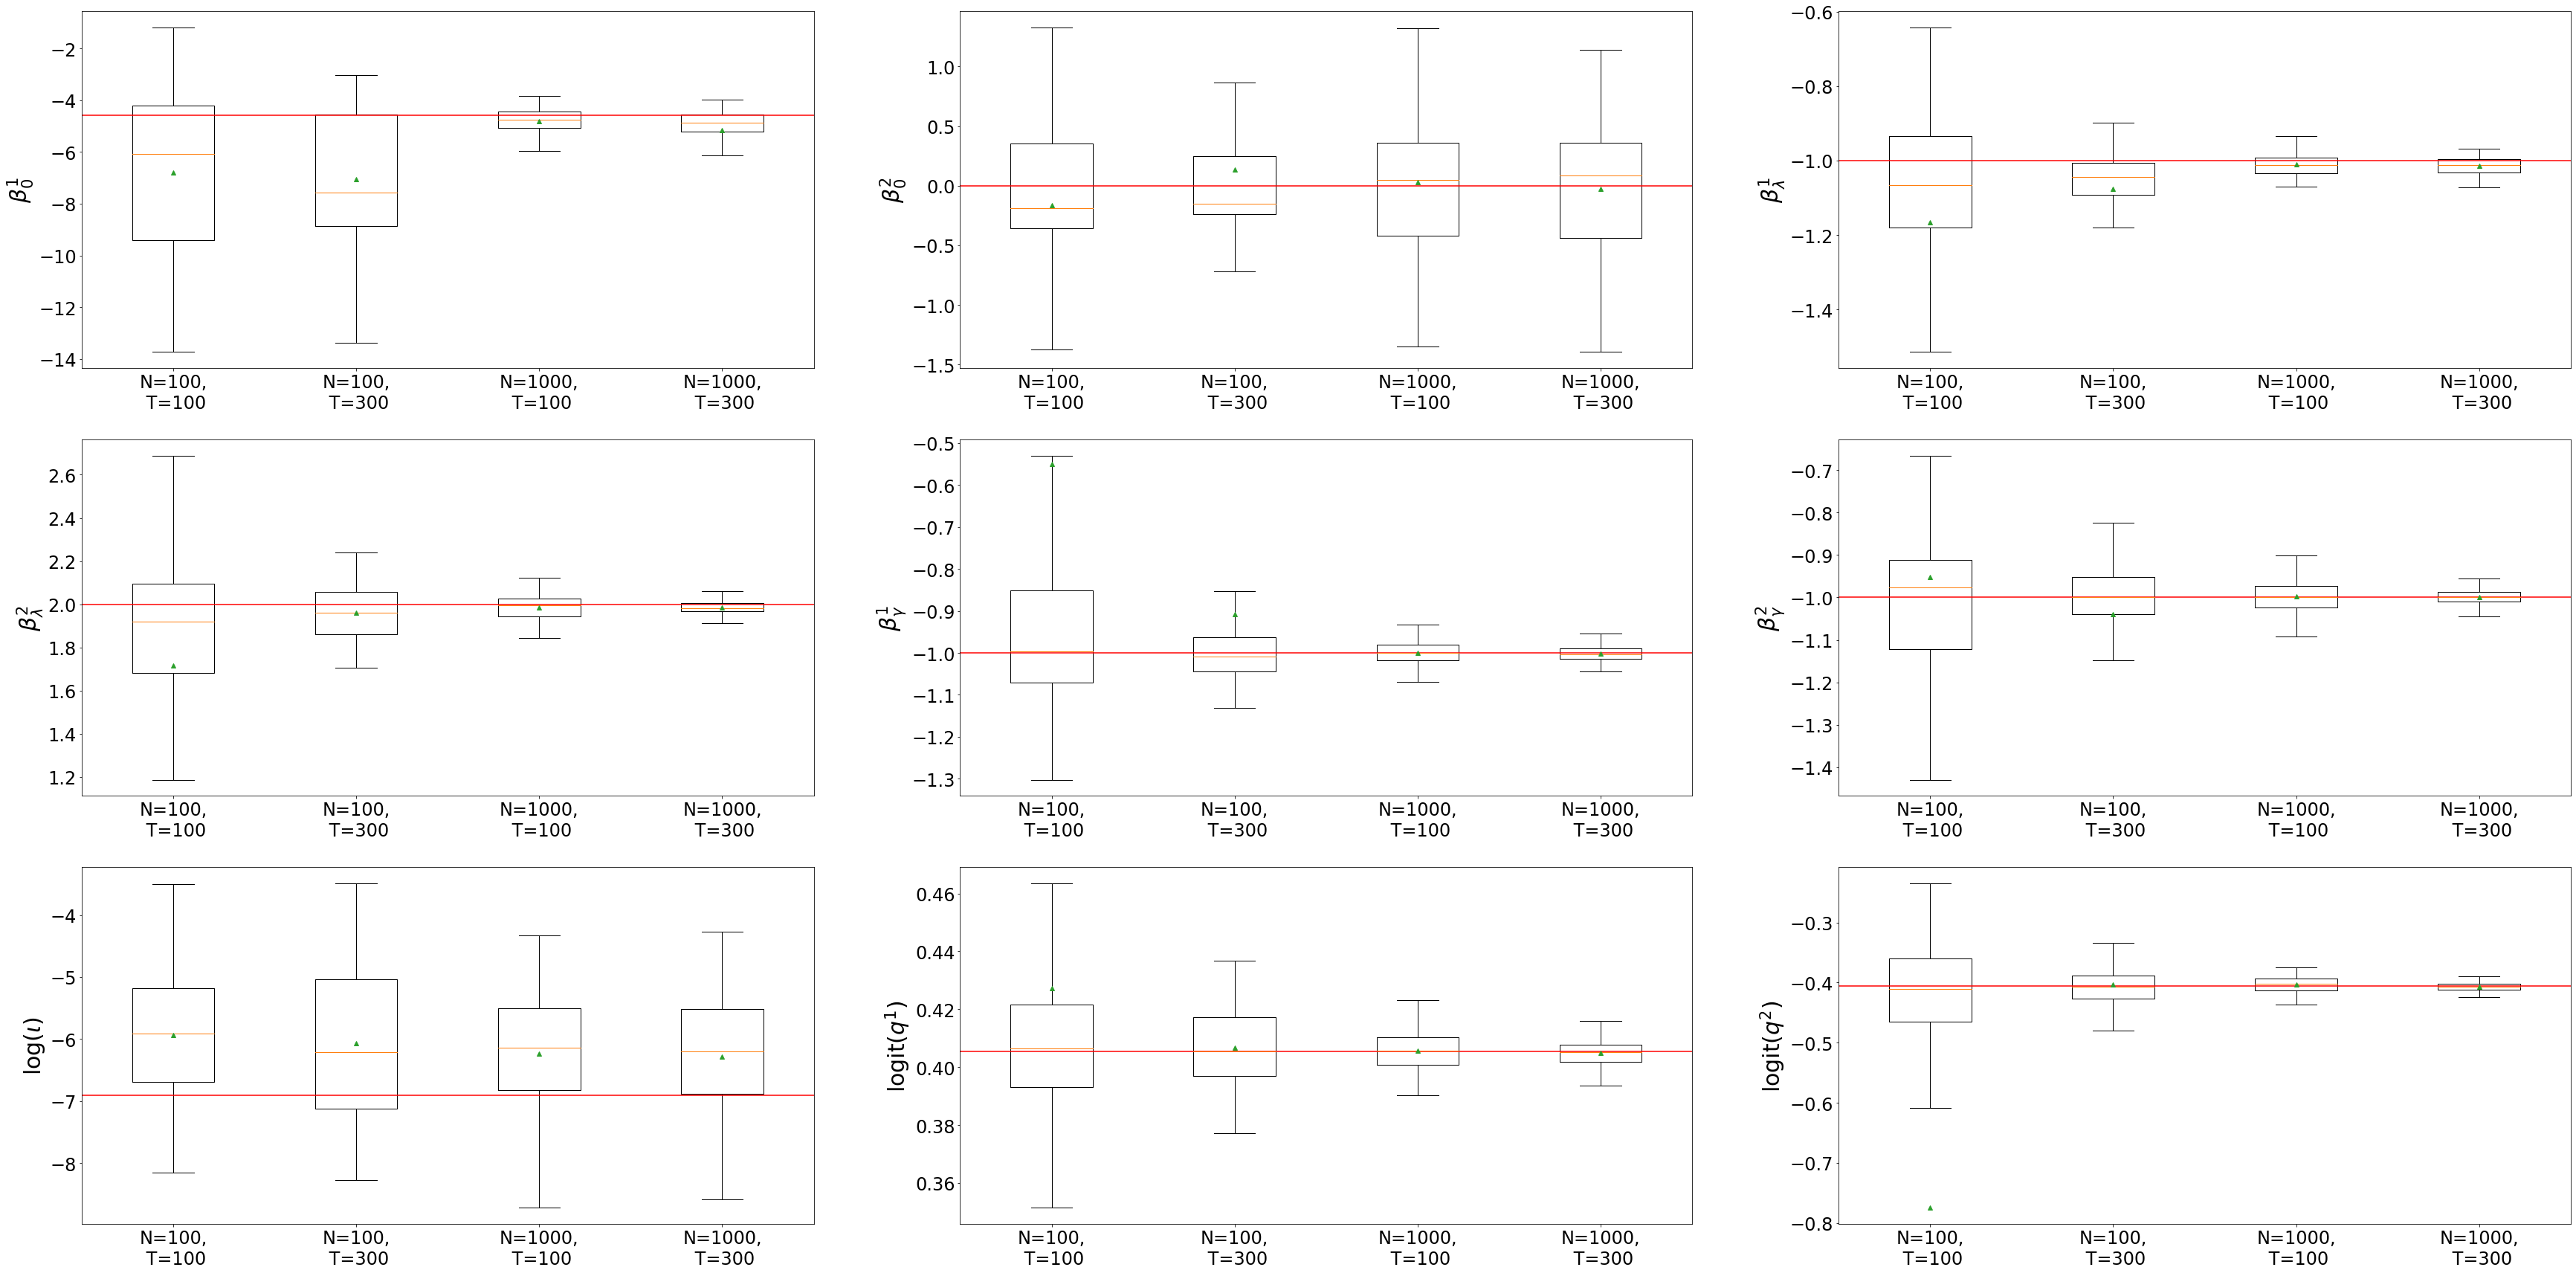

In [62]:
fig, ax = plt.subplots(3, 3, figsize=(60, 30))

names = [r"$\beta_{0}^1$", r"$\beta_{0}^2$", r"$\beta_{\lambda}^1$", r"$\beta_{\lambda}^2$", r"$\beta_{\gamma}^1$", r"$\beta_{\gamma}^2$", r"$\log(\iota)$", r"logit$(q^1)$", r"logit$(q^2)$"]
ticks_names =[r"N=100,"+"\n"+ " T=100", r"N=100,"+"\n"+ " T=300", r"N=1000,"+"\n"+ " T=100", r"N=1000,"+"\n"+ " T=300",]

for i in range(3):
    for j in range(3):
                
        ax[i, j].boxplot([parameters_sgd_path[0][:, i*3 + j], parameters_sgd_path[1][:, i*3 + j], parameters_sgd_path[2][:, i*3 + j], parameters_sgd_path[3][:, i*3 + j]], showfliers=False, showmeans=True)
        ax[i, j].axhline(y = parameters_true[ i*3 + j], color = "red")

        ax[i, j].set_ylabel(names[i*3 + j])
        ax[i, j].set_xticklabels(ticks_names)

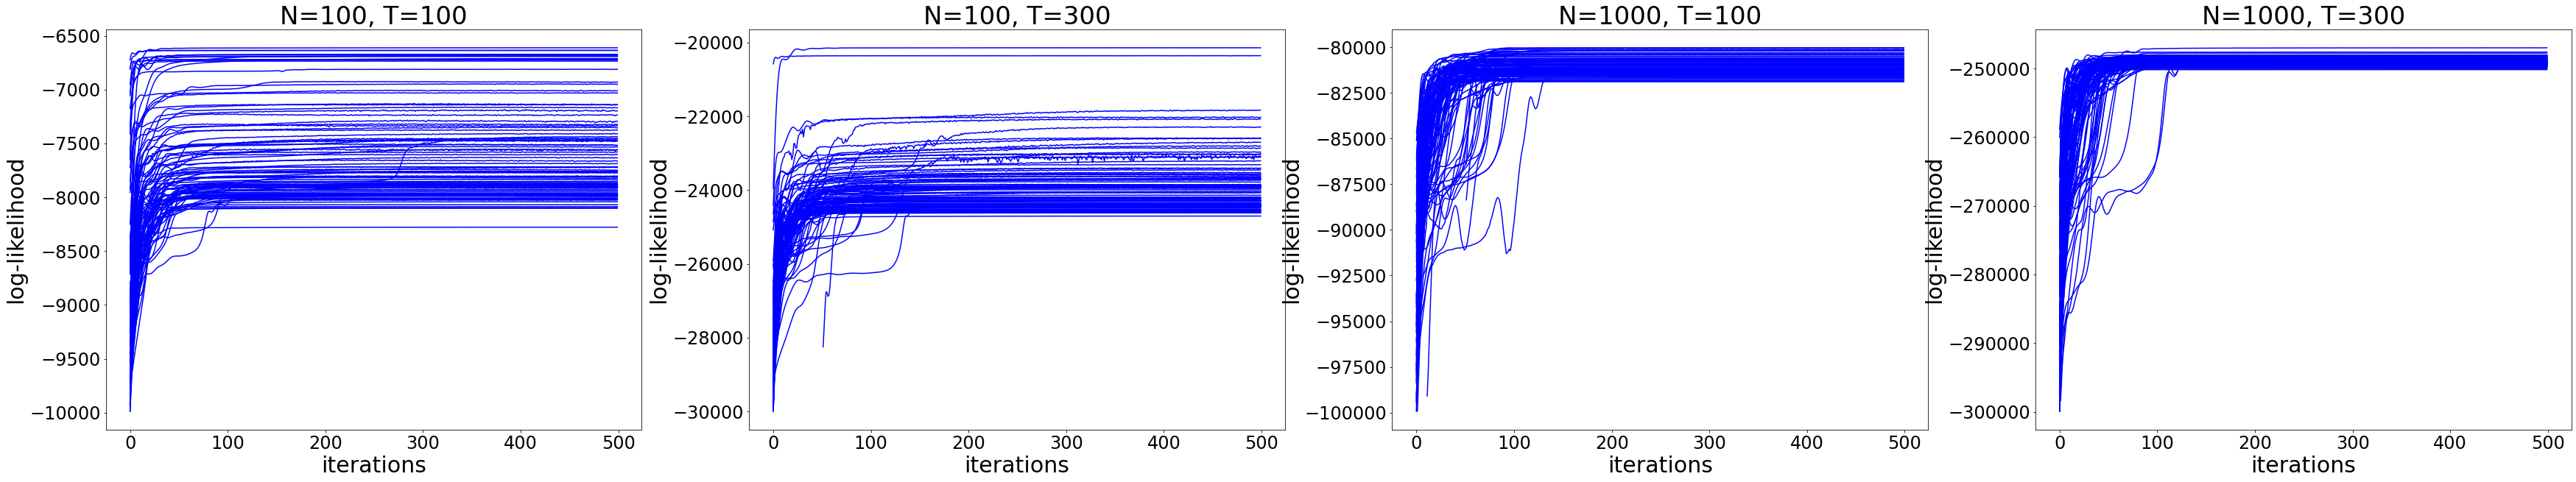

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(60, 10))

names = [r"$\beta_{\lambda}^1$", r"$\beta_{\lambda}^2$"]
ticks_names =[r"N=100,"+" T=100", r"N=100,"+" T=300", r"N=1000,"+" T=100", r"N=1000,"+" T=300",]

for j in range(4):

    for i in range(100):
            
        ax[j].plot(log_like_sgd_path[j][i,:], color = "blue")

    ax[j].set_title(ticks_names[j])
    ax[j].set_xlabel("iterations")
    ax[j].set_ylabel("log-likelihood")

In [65]:
gradients_sgd = []
hessians_sgd = []
individuals_sgd = []

for i in range(20):

        gradients_load = np.load("data/optimization/optimization_full/grad_hessian_T300_N1000/optimization_"+str(i)+"_gradients.npy")
        gradients_sgd.append(gradients_load)
        
        hessians_load = np.load("data/optimization/optimization_full/grad_hessian_T300_N1000/optimization_"+str(i)+"_hessians.npy")
        hessians_sgd.append(hessians_load)
        
        # indivs_load = np.load("data/optimization/grad_hessian_T300_N1000_barlett/optimization_"+str(i)+"_gradients.npy")
        # individuals_sgd.append(indivs_load)
    

gradients_sgd = np.concatenate(gradients_sgd, axis =0)
hessians_sgd  = np.concatenate(hessians_sgd,  axis =0)
# individuals_sgd      = np.concatenate(individuals_sgd,  axis =0)

In [66]:
theta_hat = parameters_sgd_path[3]

H_expected = np.mean(-hessians_sgd, axis = 1)

centered_gradients_sgd = gradients_sgd - np.mean(gradients_sgd, axis = 1, keepdims = True)
J_expected = (np.einsum("sbp,sbq->spq", centered_gradients_sgd, centered_gradients_sgd))/(centered_gradients_sgd.shape[1]-1)

In [67]:
top_CI = []
low_CI = []
coverage = []

# Critical value for 95% confidence level
alpha = 0.05
critical_value = chi2.ppf(1-alpha, 9)

theta = parameters_true
theta_hat = parameters_sgd_path[3]

for i in range(theta_hat.shape[0]):

    # Estimate of theta
    theta_hat_sim = theta_hat[i,...]

    G = np.dot(np.dot(H_expected[i,...], np.linalg.inv(J_expected[i,...])), H_expected[i,...])

    W = np.dot(np.dot((theta_hat_sim-theta), G), (theta_hat_sim-theta))

    # print(W)

    within_CI = ((W) <= critical_value)
    coverage.append(within_CI)

np.mean(np.stack(coverage), axis =0)

0.0

In [68]:
top_CI = []
low_CI = []
coverage = []

# Critical value for 95% confidence level
alpha = 0.05 # 2*0.05
critical_value = gaussian.ppf(1-alpha/2)

theta = parameters_true
theta_hat = parameters_sgd_path[3]

for i in range(theta_hat.shape[0]):

    # Estimate of theta
    theta_hat_sim = theta_hat[i,...]

    G = np.dot(np.dot(H_expected[i,...], np.linalg.inv(J_expected[i,...])), H_expected[i,...]) + 1e-1*np.eye(H_expected.shape[-1])

    Sigma = np.linalg.inv(G)

    top_CI_hat = theta_hat_sim + critical_value*np.sqrt(np.diag(Sigma))  
    low_CI_hat = theta_hat_sim - critical_value*np.sqrt(np.diag(Sigma)) 

    within_CI = (theta <= top_CI_hat)*(theta >= low_CI_hat)
    coverage.append(within_CI)

    top_CI.append(top_CI_hat)
    low_CI.append(low_CI_hat)


top_CI = np.stack(top_CI, axis =0)
low_CI = np.stack(low_CI, axis =0)

np.mean(np.stack(coverage), axis =0)

array([0.17, 0.05, 0.61, 0.87, 0.81, 1.  , 0.02, 0.87, 0.5 ])

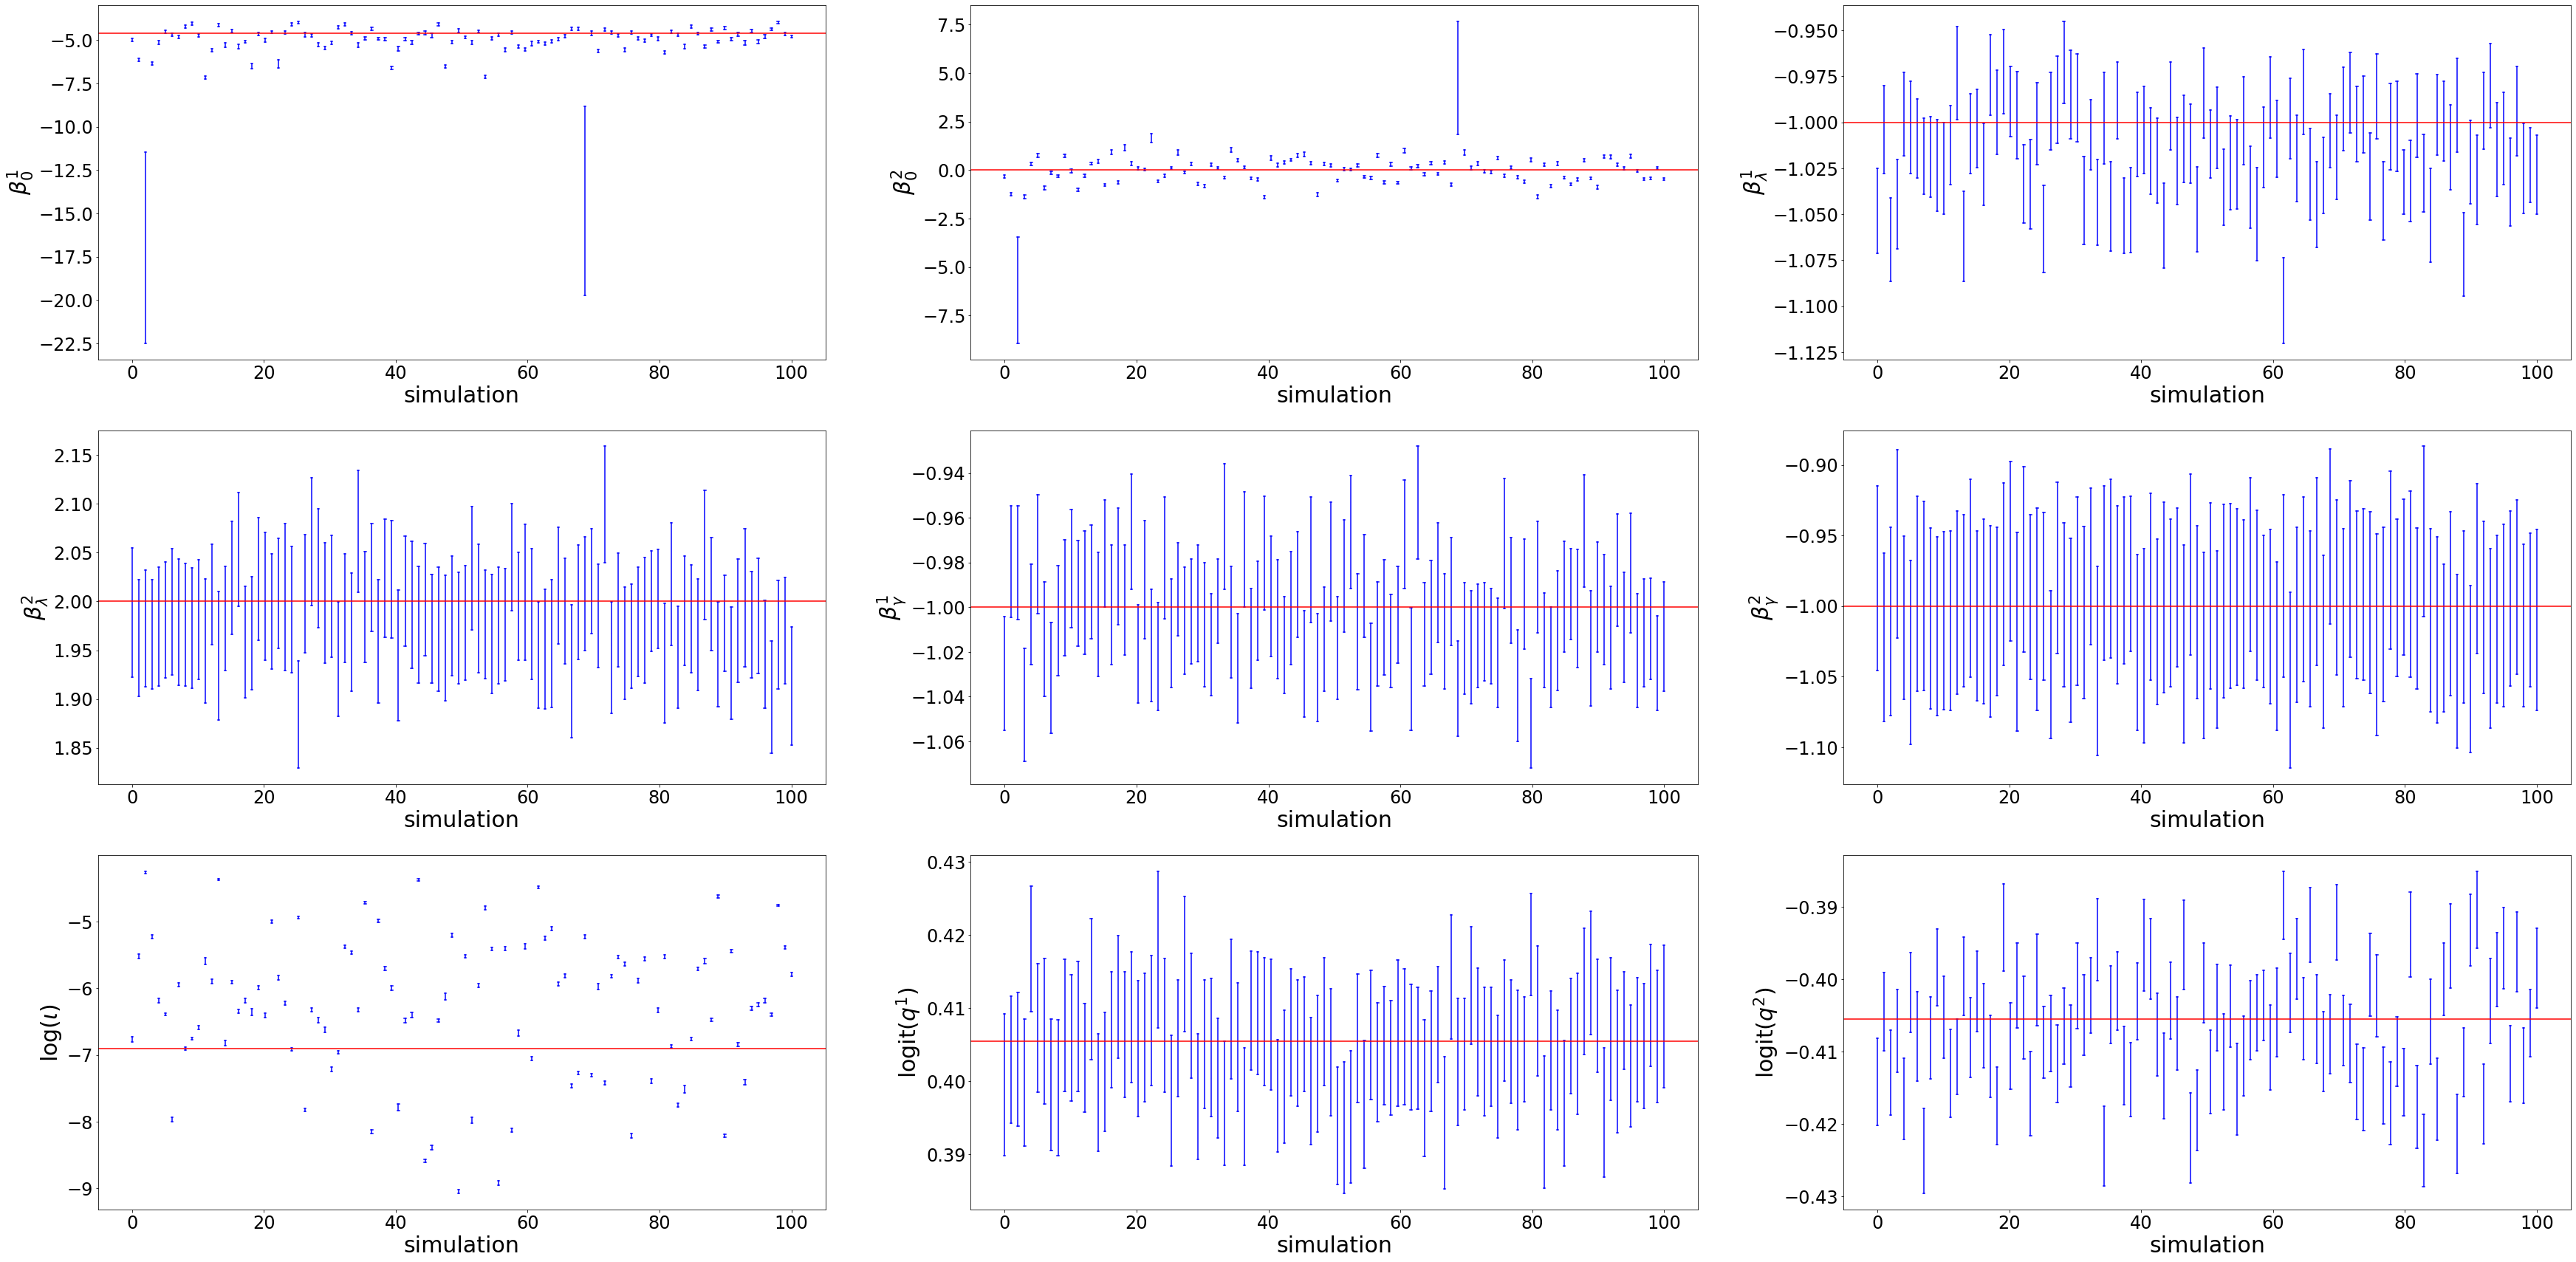

In [69]:
def plot_confidence_interval(locations, theta_hat, top_CI, low_CI, horizontal_line_width, color, ax):
    
    for i in range(theta_hat.shape[0]):

        mean = theta_hat[i]

        left = locations[i] - horizontal_line_width / 2
        top = top_CI[i]
        right = locations[i] + horizontal_line_width / 2
        bottom = low_CI[i]

        ax.plot([locations[i], locations[i]], [top, bottom], color=color)
        ax.plot([left, right], [top, top], color=color)
        ax.plot([left, right], [bottom, bottom], color=color)
        # ax.plot(locations[i], mean, 'o', color='#f44336')

fig, ax = plt.subplots(3, 3, figsize=(60, 30))

# fig.tight_layout()
# 
names = [r"$\beta_{0}^1$", r"$\beta_{0}^2$", r"$\beta_{\lambda}^1$", r"$\beta_{\lambda}^2$", r"$\beta_{\gamma}^1$", r"$\beta_{\gamma}^2$", r"$\log(\iota)$", r"logit$(q^1)$", r"logit$(q^2)$"]

for i in range(3):
    for j in range(3):

        locations = np.linspace(0, 100, theta_hat.shape[0])
        theta_hat_sim = theta_hat[:,3*i+j]
        top_CI_hat = top_CI[:,3*i+j]
        low_CI_hat = low_CI[:,3*i+j]
        horizontal_line_width = 0.25
        color = "blue"

        plot_confidence_interval(locations, theta_hat_sim, top_CI_hat, low_CI_hat, horizontal_line_width, color, ax[i,j])
        ax[i,j].axhline(y = parameters_true[3*i+j], color = "red")

        ax[i, j].set_xlabel("simulation")
        ax[i, j].set_ylabel(names[i*3 + j])


Again the Barlett case is not provide cause to big to include in the github repo.

In [70]:
# H_expected_barlett = np.mean(np.einsum("sbnp,sbnq->sbpq", individuals_sgd, individuals_sgd), axis = 1)

# J_expected_barlett = np.load("data/optimization/J_expected_barlett.npy")

In [71]:
# top_CI = []
# low_CI = []
# coverage = []

# # Critical value for 95% confidence level
# alpha = 0.05
# critical_value = chi2.ppf(1-alpha, 9)

# theta = parameters_true
# theta_hat = parameters_sgd_path[3]

# for i in range(theta_hat.shape[0]):

#     # Estimate of theta
#     theta_hat_sim = theta_hat[i,...]

#     G = np.dot(np.dot(H_expected_barlett[i,...], np.linalg.inv(J_expected_barlett[i,...])), H_expected_barlett[i,...])

#     W = np.dot(np.dot((theta_hat_sim-theta), G), (theta_hat_sim-theta))

#     # print(W)

#     within_CI = ((W) <= critical_value)
#     coverage.append(within_CI)

# np.mean(np.stack(coverage), axis =0)

In [72]:
# top_CI = []
# low_CI = []
# coverage = []

# # Critical value for 95% confidence level
# alpha = 0.05
# critical_value = chi2.ppf(1-alpha, 9)

# theta = parameters_true
# theta_hat = parameters_sgd_path[3]

# for i in range(theta_hat.shape[0]):

#     # Estimate of theta
#     theta_hat_sim = theta_hat[i,...]

#     G = np.dot(np.dot(H_expected_barlett[i,...], np.linalg.inv(J_expected_barlett[i,...])), H_expected_barlett[i,...])

#     W = np.dot(np.dot((theta_hat_sim-theta), G), (theta_hat_sim-theta))

#     # print(W)

#     within_CI = ((W) <= critical_value)
#     coverage.append(within_CI)

# np.mean(np.stack(coverage), axis =0)

In [73]:
# def plot_confidence_interval(locations, theta_hat, top_CI, low_CI, horizontal_line_width, color, ax):
    
#     for i in range(theta_hat.shape[0]):

#         mean = theta_hat[i]

#         left = locations[i] - horizontal_line_width / 2
#         top = top_CI[i]
#         right = locations[i] + horizontal_line_width / 2
#         bottom = low_CI[i]

#         ax.plot([locations[i], locations[i]], [top, bottom], color=color)
#         ax.plot([left, right], [top, top], color=color)
#         ax.plot([left, right], [bottom, bottom], color=color)
#         # ax.plot(locations[i], mean, 'o', color='#f44336')

# fig, ax = plt.subplots(3, 3, figsize=(60, 30))

# # fig.tight_layout()

# for i in range(3):
#     for j in range(3):

#         locations = np.linspace(0, 100, theta_hat.shape[0])
#         theta_hat_sim = theta_hat[:,3*i+j]
#         top_CI_hat = top_CI[:,3*i+j]
#         low_CI_hat = low_CI[:,3*i+j]
#         horizontal_line_width = 0.25
#         color = "blue"

#         plot_confidence_interval(locations, theta_hat_sim, top_CI_hat, low_CI_hat, horizontal_line_width, color, ax[i,j])
#         ax[i,j].axhline(y = parameters_true[3*i+j], color = "red")
        
#         ax[i, j].set_xlabel("simulation")
#         ax[i, j].set_ylabel(names[i*3 + j])
        

# SimBa-CL for the foot and mouth data

For the FM data the procedure follows the same steps as above. We do not recommend to run the following cells for the complexity of the problem.

In [75]:
########################################
# load the data
n_cattles   = tf.convert_to_tensor(np.load("data/FM_data/n_cattles_cumbria.npy"  ), dtype = tf.float32)
n_sheep     = tf.convert_to_tensor(np.load("data/FM_data/n_sheep_cumbria.npy"    ), dtype = tf.float32)
farms_coord = tf.convert_to_tensor(np.load("data/FM_data/farms_coord_cumbria.npy"), dtype = tf.float32)

N = tf.shape(n_sheep)[0]

y_CUMBRIA = np.load("data/FM_data/Y_n_dense_cumbria.npy")
y_CUMBRIA = tf.expand_dims(tf.transpose(tf.convert_to_tensor(y_CUMBRIA, dtype = tf.float32)), axis = -1)
y_CUMBRIA = tf.concat((tf.zeros(tf.shape(y_CUMBRIA)), tf.zeros(tf.shape(y_CUMBRIA)), y_CUMBRIA, tf.zeros(tf.shape(y_CUMBRIA))), axis =-1)[:101,...]

input_0 = y_CUMBRIA
input_kernel = n_cattles, n_sheep

parallel_simulations = 100

optimization_steps = 3000

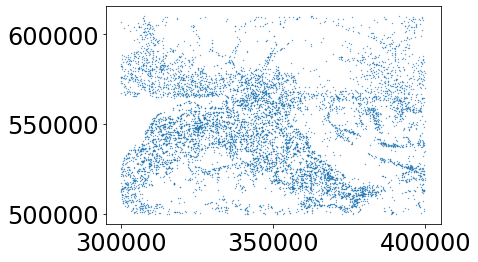

In [77]:
plt.scatter(farms_coord[:,0], farms_coord[:,1], s = 0.1)

In [ ]:
# Parameters bounds
bnds = ((1, 2), (-1, 1), (-1, 1), (0, 1), (-1, 1), (0, 1), (1.5, 3), (1, 2))

T = tf.cast(y_CUMBRIA.shape[0], dtype = tf.float32)

seed_sim, seed_init_cond = tfp.random.split_seed( 123, n= 2, salt='all_param_sim_init')

seed_init_cond_split = tfp.random.split_seed( seed_init_cond[0], n= 2, salt='initial_cond_all_param')

In [ ]:
log_likelihood_optim = np.zeros((optimization_steps))

# Load initial conditions
initial_parameters = np.array([np.random.uniform(bnds[1][0], bnds[1][1], 1)[0], 
                                np.random.uniform(bnds[2][0], bnds[2][1], 1)[0], np.random.uniform(bnds[3][0], bnds[3][1], 1)[0], 
                                np.random.uniform(bnds[4][0], bnds[4][1], 1)[0], np.random.uniform(bnds[5][0], bnds[5][1], 1)[0],
                                np.random.uniform(bnds[6][0], bnds[6][1], 1)[0], ], dtype = np.float32)

# Step 2: Define your initial parameters_var
parameters = tf.Variable(initial_value=initial_parameters, dtype=tf.float32)

# Define the learning rate 
basic_lr = 0.1

# Step 3: Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = basic_lr)

seed_init_cond_optim = tfp.random.split_seed( seed_init_cond_split[0][0], n= optimization_steps+1, salt='optim_steps_all_param')

# Step 4: Define the training loop
for epoch in range(optimization_steps):

    loss, gradients = simba_loss_grad_FM(input_0, input_kernel, farms_coord, parameters, y_CUMBRIA, T, parallel_simulations, seed_init_cond_optim[epoch][0], FM_initial_dense_recovery)

    log_likelihood_optim[epoch] = -T*loss.numpy()

    if epoch%10==0:

        if (tf.math.is_nan(loss)):
    
            # Load initial conditions
            initial_parameters = np.array([np.random.uniform(bnds[1][0], bnds[1][1], 1)[0], 
                                            np.random.uniform(bnds[2][0], bnds[2][1], 1)[0], np.random.uniform(bnds[3][0], bnds[3][1], 1)[0], 
                                            np.random.uniform(bnds[4][0], bnds[4][1], 1)[0], np.random.uniform(bnds[5][0], bnds[5][1], 1)[0],
                                            np.random.uniform(bnds[6][0], bnds[6][1], 1)[0], ], dtype = np.float32)

            # Step 2: Define your initial parameters_var
            parameters = tf.Variable(initial_value=initial_parameters, dtype=tf.float32)

    # Apply gradients to update the parameters_var
    optimizer.apply_gradients(zip(gradients, [parameters]))